In [ ]:
%load_ext autoreload
%autoreload 2
import logging
import sys
import time
from dataclasses import dataclass
from enum import Enum

from autoscript_sdb_microscope_client.structures import AdornedImage, StagePosition, ManipulatorPosition
from liftout.fibsem.sample import Sample, Lamella, AutoLiftoutState, AutoLiftoutStage

### New Sample Data Structure
Prototyping for the new sample dataclass, and filesystem structures


In [ ]:
import random
import os
from pprint import pprint

from liftout.fibsem.sample import create_experiment, load_experiment
from pathlib import Path

sample_name = "test_sample2"
sample = create_experiment(experiment_name=sample_name, path="")

for i in range(1, random.randint(6, 8)):

    lamella = Lamella(path=sample.path, number=i)
    lamella.lamella_coordinates = StagePosition(i, i, i, i, i)
    lamella.landing_coordinates = StagePosition(i, i, i, i, i)

    import random
    lamella.current_state.stage   = random.choice([stage for stage in AutoLiftoutStage]) 

    for j in range(random.randint(1, 6)):
        lamella.history.append(lamella.current_state)

    sample.positions[lamella._number] = lamella

pprint(sample)
pprint(sample.positions)

# save to file
sample.save()

# load from file
sample2 = load_experiment(sample.path)

# validation
assert sample.path == sample2.path
for i in sample.positions:
    assert sample.path[i] == sample2.path[i]
    assert sample.positions[i].lamella_coordinates == sample2.positions[i].lamella_coordinates
    assert sample.positions[i].landing_coordinates == sample2.positions[i].landing_coordinates
    assert sample.positions[i]._id == sample2.positions[i]._id
    assert sample.positions[i]._petname == sample2.positions[i]._petname
    assert sample.positions[i].current_state == sample2.positions[i].current_state
    assert sample.positions[i].history == sample2.positions[i].history
    print(f"lamella {i} passed.")

# updates to dictionarys follow reference, not sure about others

# sample.save()


### New Protocol
- Splitting the protocol into separate files. 
    - load into a single settings, dictionary
    - save protocol into individual files 
    - load protocol individually
    - possibly change to loading experiments

In [ ]:
base_path = r"C:\Users\pcle0002\Documents\repos\autoliftout\liftout"

from pprint import pprint
from liftout.utils import load_full_config

system_fname = os.path.join(base_path, "config", "system.yaml")
calibration_fname = os.path.join(base_path, "config", "calibration.yaml")
protocol_fname = os.path.join(base_path, "protocol", "protocol.yaml")

settings = load_full_config(
    system_fname, 
    calibration_fname, 
    protocol_fname
)

pprint(settings)


def update_protocol(settings: dict, step: str, fname: Path) -> None:

    print("step: ", step)
    pprint(settings["protocol"][step])
    print("fname: ", fname)
    print("-"*50)


# from liftout.fibsem.milling import get_milling_protocol_stages
# protocol_stages = get_milling_protocol_stages(settings, "lamella")

# pprint(protocol_stages)

for k in settings["protocol"].keys():
    update_protocol(settings, k, None)


In [ ]:
import matplotlib.pyplot as plt
from autoscript_sdb_microscope_client.structures import AdornedImage
import pandas as pd
from liftout.detection.utils import load_detection_result, plot_detection_result
from pathlib import Path


# TODO: aggregate multiple datasets together...

path = r"C:\Users\Admin\Github\autoliftout\tools\test\label\data.csv"
base = os.path.dirname(path)
df = pd.read_csv(path)
display(df)

for idx, row in df.iterrows():
    
    det_result = load_detection_result(base, row)
    fig = plot_detection_result(det_result)

    plt.show()
    plt.close()

#### CRossCorrelation Refactor

In [ ]:
from autoscript_sdb_microscope_client.structures import AdornedImage
from liftout.fibsem import calibration, acquire
from liftout.fibsem import utils as fibsem_utils
import glob
import os
import random
import matplotlib.pyplot as plt

from pprint import pprint
path = r"C:\Users\Admin\Github\autoliftout\tools\test\label"
filenames = glob.glob(os.path.join(path, "*.tif"))



In [ ]:
microscope, settings, image_settings = fibsem_utils.quick_setup()

In [ ]:
eb_image, ib_image = acquire.take_reference_images(microscope, image_settings)


plt.imshow(eb_image.data, cmap="gray")
plt.show()



In [ ]:
eb_image.metadata.scan_settings.scan_size

from liftout import utils
from liftout.fibsem.acquire import ImageSettings, BeamType


pprint(image_settings)
image_settings = calibration.match_image_settings(ib_image, image_settings)

pprint(image_settings)




### State Testing


In [ ]:
%load_ext autoreload 
%autoreload 2
from liftout import autoliftout
from liftout.fibsem import utils as fibsem_utils
from liftout.fibsem.sample import Sample, Lamella, create_experiment

microscope, settings, image_settings = fibsem_utils.quick_setup()

print(image_settings.save_path)

sample = create_experiment("my_experiment", image_settings.save_path)

for no in range(1, 3):
    lamella = Lamella(sample.path, no)
    sample.positions[lamella._number] = lamella

from pprint import pprint 


In [ ]:
key = list(sample.positions.keys())[0]
lamella = sample.positions[key]
sample = autoliftout.end_of_stage_update(microscope, sample, lamella)

### CrossCorrelation

In [ ]:
%load_ext autoreload
%autoreload 2

from liftout.fibsem import calibration
from autoscript_sdb_microscope_client.structures import AdornedImage

from pprint import pprint


img1 = AdornedImage.load("../test_image.tif")
img2 = AdornedImage.load("../test_image.tif")


import matplotlib.pyplot as plt
plt.imshow(img1.data, cmap="gray")
plt.show()



xcorr = calibration.crosscorrelation(img1.data, img2.data, bp="yes", lp=128, hp=6, sigma=6)
xcorr = calibration.crosscorrelation(img1.data, img2.data, bp=True, lp=128, hp=6, sigma=6)
dx, dy, xcorr = calibration.shift_from_crosscorrelation(img1, img2, lowpass=128, highpass=6, sigma=6, use_rect_mask=True)

plt.imshow(xcorr)
plt.show()

print(dx, dy)


### Edge Detection

In [ ]:
## edge detection

%load_ext autoreload
%autoreload 2

from liftout.detection import detection
from liftout.fibsem import calibration
from autoscript_sdb_microscope_client.structures import AdornedImage
import matplotlib.pyplot as plt

from pprint import pprint

img = AdornedImage.load("../test_image.tif")
centre = img.data.shape[0] // 2, img.data.shape[1] // 2
edge_px, edges_mask = detection.detect_landing_edge(img.data, centre)


fig = plt.figure(figsize=(10, 10))
plt.imshow(edges_mask, cmap="gray")
plt.plot(centre[1], centre[0], "c+", ms=50)
plt.plot(edge_px[1], edge_px[0], "r+", ms=50)
plt.show()

print("centre: ", centre)
print("closest edge: ", edge_px)

In [ ]:
import glob
import random
import os

# NB: problem is bad eucentricty? ib works well, eb not so much
# snap to closest edge is pretty good

filenames = glob.glob("data/**/**/*landing*high_res_*b.tif")
fname = random.choice(filenames)

print(f"{len(filenames)} selected.")
print(f"file: {os.path.basename(fname)}")


for fname in filenames[:2]:
    img = AdornedImage.load(fname)
    centre = img.data.shape[0] // 2, img.data.shape[1] // 2
    edge_px, edges_mask = detection.detect_landing_edge(img.data, centre)

    fig = plt.figure(figsize=(15, 15))
    plt.imshow(edges_mask, cmap="gray")
    plt.plot(centre[1], centre[0], "c+", ms=100, markeredgewidth=2)
    plt.plot(edge_px[1], edge_px[0], "r+", ms=100, markeredgewidth=2)
    plt.plot((centre[1], edge_px[1]), (centre[0], edge_px[0]), "w", ms=100, markeredgewidth=2)
    plt.show()

    print("centre: ", centre)
    print("closest edge: ", edge_px)


In [ ]:
# fig.savefig('test.png',bbox_inches='tight',transparent=True, pad_inches=0)


In [ ]:
# Detection Model

%load_ext autoreload 
%autoreload 2

import glob
import random
import os
from pprint import pprint
from liftout.detection import detection
from liftout.fibsem import calibration
from autoscript_sdb_microscope_client.structures import AdornedImage
import matplotlib.pyplot as plt

from liftout.detection import utils as det_utils

import numpy as np
from liftout.detection.detection import DetectionType
from liftout.detection.DetectionModel import DetectionModel
from PIL import Image

sample = "dm*"
_id = "*e2e6a"  
_id = "*94bb0" 
_id = "*"
img_type = "*"
search = "landing_needle_land_sample"
filenames = glob.glob(f"data/{sample}/{_id}/*{search}*{img_type}.tif") 
random.shuffle(filenames)

print(f"{len(filenames)} selected.")

weights_file = r"C:\Users\pcle0002\Documents\repos\autoliftout\liftout\model\models\boost_n05_model.pt"
model = DetectionModel(weights_file=weights_file)

N_IMAGES = 25

for fname in filenames[:N_IMAGES]:
    print(f"file: {os.path.basename(fname)}")

    adorned_img = AdornedImage.load(fname)

    det = detection.locate_shift_between_features(
        model, adorned_img, shift_type=(DetectionType.NeedleTip, DetectionType.LandingPost) 
    )

    fig = det_utils.plot_detection_result(det)
    plt.show()
    plt.close()

    # fig = plt.figure(figsize=(15, 15))
    # plt.imshow(detection.edge_detection(adorned_img.data, sigma=3), cmap="gray")
    # plt.show()
    
    # pprint(det.features)


In [ ]:
filenames = glob.glob("data/**/**/*landing_*b.tif")

print(f"{len(filenames)} filenames")
pprint(filenames)

In [ ]:
## Detect Brightness Changes

%load_ext autoreload 
%autoreload 2

import glob
import random
import os
from pprint import pprint
from liftout.detection import detection
from liftout.fibsem import calibration
from autoscript_sdb_microscope_client.structures import AdornedImage
import matplotlib.pyplot as plt

from liftout.detection import utils as det_utils

import numpy as np
from liftout.detection.detection import DetectionType
from liftout.detection.DetectionModel import DetectionModel
from PIL import Image


# Get baseline brightness
# it doesnt need to be a global threshold... brightness should increase when need lands
# just need to look for the increase?

sample = "dm*"
_id = "*e2e6a"  
_id = "*94bb0" 
_id = "*4f708"
img_type = "lowres_ib"

filenames = glob.glob(f"data/{sample}/{_id}/*needle_liftout*post*{img_type}.tif") + glob.glob(f"data/{sample}/{_id}/*needle_liftout_landed*{img_type}.tif") 
# random.shuffle(filenames)

print(f"{len(filenames)} selected.")

weights_file = r"C:\Users\pcle0002\Documents\repos\autoliftout\liftout\model\models\boost_n05_model.pt"
model = DetectionModel(weights_file=weights_file)

N_IMAGES = len(filenames)

## INVESTIGATE: 
# does the brightness meaningfully increase when needle is in frame but not landed?
# what are the other factors that influence this?
# measure the needle current?? microscope.state.specimen_current??

landed = []
pre_landing = []

def measure_brightness(img: AdornedImage, crop_size: int = None) -> float:
    cx, cy = img.data.shape[1] //2, img.data.shape[0] // 2

    if crop_size is not None:
        img = img.data[cy-crop_size:cy+crop_size, cx-crop_size:cx+crop_size]
    else:
        img = img.data

    return np.mean(img), img


history = []

for fname in filenames[:N_IMAGES]:
    print(f"file: {os.path.dirname(os.path.dirname(fname))}, {os.path.dirname(fname)[-5:]}, {os.path.basename(fname)}")

    adorned_img = AdornedImage.load(fname)

    # only use the centre of the image???
    # brightness, contrast = np.mean(crop_img), np.std(crop_img)

    brightness, img = measure_brightness(adorned_img, crop_size=250)
    print(f"Brightness: {brightness}") #, contrast: {contrast}")


    if "landed" in fname:
        landed.append(brightness)
    else:
        pre_landing.append(brightness)

    history.append(brightness)

    plt.imshow(img, cmap="gray")
    plt.show()
    
plt.hist(landed, color="blue", alpha=0.5, label="landed", bins=10)
plt.hist(pre_landing, color="red", alpha=0.5, label="pre_landing", bins=10)
plt.legend(loc="best")
plt.show()

print(f"baseline: mean={np.mean(pre_landing)}, std={np.std(pre_landing)}" )
print(f"baseline: mean={np.mean(landed)}, std={np.std(landed)}" )

plt.plot(history, color="blue", label="brightness")
plt.show()


# TODO
# need to get a baseline brightness



In [ ]:
filenames = glob.glob("data/dm*/**/*needle_liftout*ib.tif")

print(f"{len(filenames)} filenames")
pprint(filenames)

In [ ]:
# New liftout strategy

# insert needle

# line up in electron (xy)
#   - should be above the lamella

# loop:
#   move needle down (z)
#   image, check brightness level
#   if meets threshold -> 
#       needle has landed, return
#   continue



In [ ]:
## soft mask lamellla
## cosine stretch

%load_ext autoreload 
%autoreload 2

import glob
import random
import os
from pprint import pprint
from liftout.detection import detection
from liftout.fibsem import calibration
from autoscript_sdb_microscope_client.structures import AdornedImage
import matplotlib.pyplot as plt

from liftout.detection import utils as det_utils

import numpy as np
from liftout.detection.detection import DetectionType
from liftout.detection.DetectionModel import DetectionModel
from liftout.fibsem import calibration
from PIL import Image

sample = "dm*"
_id = "*e2e6a"  
_id = "*94bb0" 
_id = "*4f708"
img_type = "*_ib"
search = "*lamella*"

In [ ]:
# TODO:


In [ ]:
from liftout import utils 

settings = utils.load_full_config()

sample = "dm*"
_id = "*e2e6a"  
_id = "*94bb0" 
_id = "*4f708"
img_type = "*_*b"
search = "*ref_trench*"

weights_file = r"C:\Users\pcle0002\Documents\repos\autoliftout\liftout\model\models\boost_n05_model.pt"
model = DetectionModel(weights_file=weights_file)


filenames = glob.glob(f"data/{sample}/{_id}/*{search}*{img_type}.tif") 

print(f"{len(filenames)} filenames")

for fname in filenames:

# fname = filenames[0]
    print(f"file: {os.path.dirname(os.path.dirname(fname))}, {os.path.dirname(fname)[-5:]}, {os.path.basename(fname)}")
    img = AdornedImage.load(fname)

    mask = create_lamella_mask(img, settings)
    # mask = create_vertical_mask(img)

    masked_img = AdornedImage(data=np.asarray(img.data * mask, dtype=np.uint8), metadata=img.metadata)

    # fig, ax = plt.subplots(1, 2, figsize=(15, 15))
    # ax[0].imshow(img.data, cmap="gray")
    # ax[1].imshow(masked_img.data, cmap="gray")
    # plt.show()

    det = detection.locate_shift_between_features(
        model, masked_img, shift_type=(DetectionType.ImageCentre, DetectionType.LamellaCentre)
    )

    fig, ax = plt.subplots(1, 3, figsize=(15, 15))
    ax[0].imshow(img.data, cmap="gray")
    ax[1].imshow(masked_img.data, cmap="gray")
    ax[2].imshow(det.display_image)
    plt.show()

In [ ]:

# reference    
"ref_trench_low_res_eb"
"ref_trench_high_res_eb"
"ref_trench_low_res_ib"
"ref_trench_high_res_ib"


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
9 selected.
file: landing_needle_land_sample_lowres_after_z_move_label.tif
[False  True]


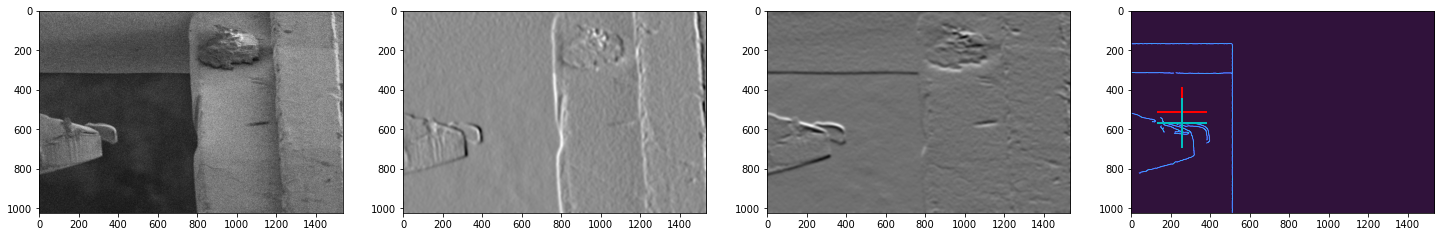

file: landing_needle_land_sample_lowres_after_y_move_label.tif
[False  True]


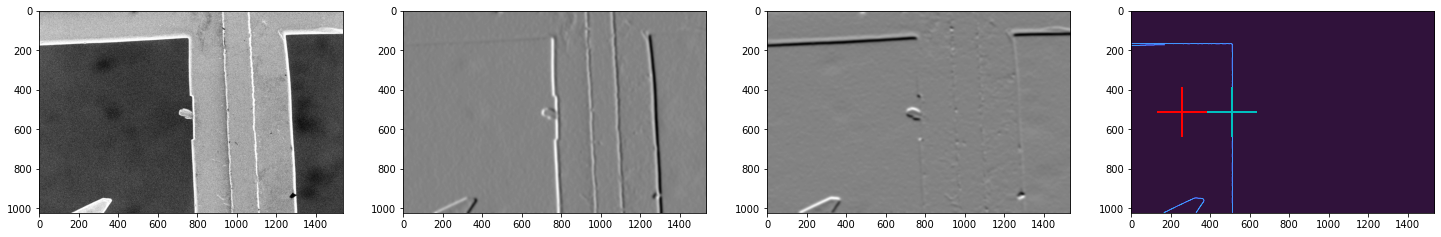

file: landing_needle_land_sample_lowres_after_y_move_label.tif
[False  True]


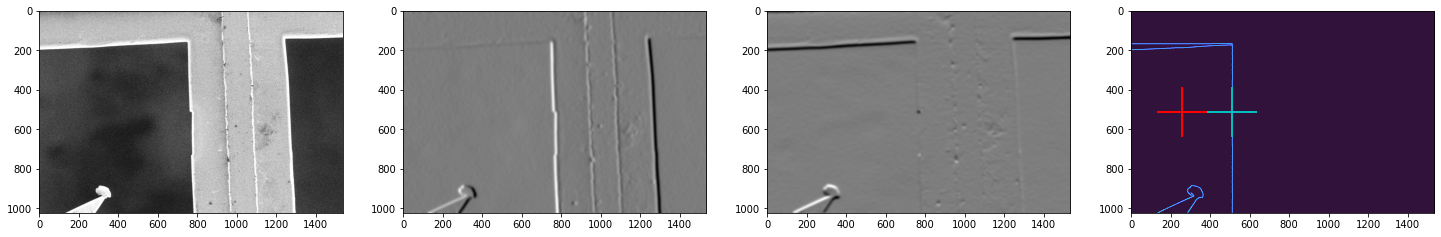

file: landing_needle_land_sample_lowres_after_z_move_label.tif
[False  True]


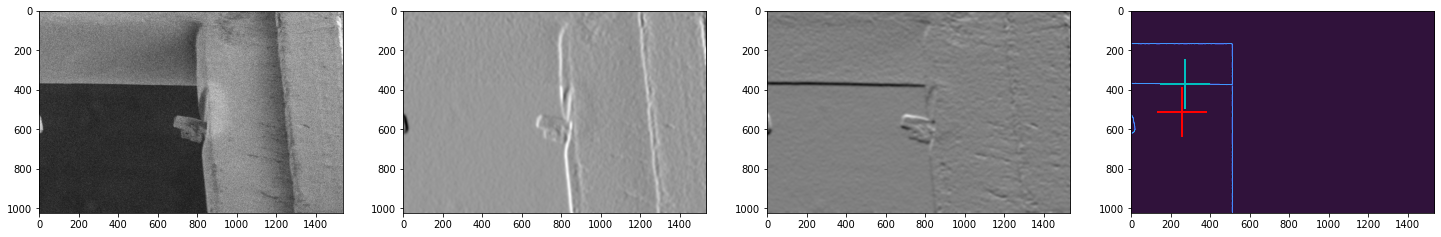

file: landing_needle_land_sample_lowres_after_z_move_label.tif
[False  True]


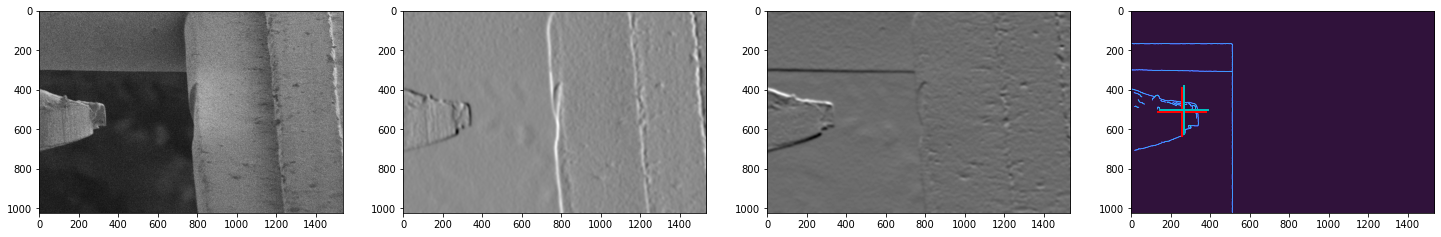

In [53]:
# land lamella with edge detection

%load_ext autoreload 
%autoreload 2

import glob
import random
import os
from pprint import pprint
from liftout.detection import detection
from liftout.fibsem import calibration
from autoscript_sdb_microscope_client.structures import AdornedImage
import matplotlib.pyplot as plt

from liftout.detection import utils as det_utils

import numpy as np
from liftout.detection.detection import DetectionType
from liftout.detection.DetectionModel import DetectionModel
from PIL import Image
from liftout.fibsem.structures import Point
from skimage import filters


sample = "dm*"
_id = "*e2e6a"  
_id = "*94bb0" 
_id = "*"
img_type = "*label"
search = "landing_needle_land_sample"
filenames = glob.glob(f"data/{sample}/{_id}/*{search}*{img_type}.tif") 
random.shuffle(filenames)

print(f"{len(filenames)} selected.")

weights_file = r"C:\Users\pcle0002\Documents\repos\autoliftout\liftout\model\models\boost_n05_model.pt"
model = DetectionModel(weights_file=weights_file)

N_IMAGES = 5

for fname in filenames[:N_IMAGES]:
    print(f"file: {os.path.basename(fname)}")

    img = AdornedImage.load(fname)

    # det = detection.locate_shift_between_features(
    #     model, adorned_img, shift_type=(DetectionType.NeedleTip, DetectionType.LandingPost) 
    # )

    # fig = det_utils.plot_detection_result(det)
    # plt.show()
    # plt.close()

    mask = np.zeros_like(img.data)
    cy, cx = mask.shape[0] // 2, mask.shape[1] // 3
    mask[cy//3:, 0:cx] = 1
    # mask[cy-100:cy+250:, 0:cx] = 1
    
    masked_img = AdornedImage(data=np.asarray(img.data * mask, dtype=np.uint8), metadata=img.metadata)

    

    edge_img = detection.edge_detection(filters.gaussian(masked_img.data, sigma=3), sigma=3)

    start_px = Point(x=cx//2, y=cy)

    end_px, edge_img = detection.detect_closest_edge(masked_img.data, (start_px.y, start_px.x))

    # detect closest edge?

    # detect right edge?

    print(np.unique(edge_img))


    # detection.

    edges_x = filters.sobel_v(filters.gaussian(img.data, sigma=6))
    edges_y = filters.sobel_h(filters.gaussian(img.data, sigma=6))

    fig, ax = plt.subplots(1, 4, figsize=(25, 20))

    ax[0].imshow(img.data, cmap="gray")
    ax[1].imshow(edges_x, cmap="gray")
    ax[2].imshow(edges_y, cmap="gray")

    ax[3].imshow(edge_img, cmap="turbo")

    # ax[3].imshow(masked_img.data, cmap="gray")
    ax[3].plot(start_px.x, start_px.y, "r+", ms=50, markeredgewidth=2)
    ax[3].plot(end_px.x, end_px.y, "c+", ms=50, markeredgewidth=2)
    
    # ax[3].plot([0, cx], [cy-100, cy-100], "w--", ms=50, markeredgewidth=2)
    # ax[3].plot([0, cx], [cy+100, cy+100], "w--", ms=50, markeredgewidth=2)

    # ax[2].imshow(img.data, cmap="gray")
    plt.show()
    
    # pprint(det.features)


In [ ]:
## perspective transform / cosine stretch

